# Udacity - Machine Learning Engineer Nanodegree Program

## Final Capstone Project

### Stock Price Prediction Using Machine Learning
In this project, I will use the power of Machine Learning to predict the Stock closing price using some of models namely LSTM and GRU to predict the Amazon's (FAANG stock) closing price.

### Common Modules for the project

In [1]:
import quandl
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.layers import BatchNormalization

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM,GRU
from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from math import sqrt

/Users/i850472/local/tools/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Stock data downloader

Pull the data from Quandl first and add the 50days, 100days, 200days into [50, 100, 200]
In the Quandl database, Open, High, Low, Close, Volume are all adjusted.

In [2]:
## Stock downloader..
def download_stock_data(stock):
    columns = ['date','adj_open','adj_low','adj_high','adj_volume','adj_close']
    quandl.ApiConfig.api_key = 'RcePNacJwS3WiJR-kww_'
    
    data = quandl.get_table('WIKI/PRICES', ticker = stock, qopts = { 'columns': columns })
     # Renaming all the columns so that we can use the old version code
    data.rename(columns={'adj_open': 'Open', 'adj_high': 'High', 'adj_low': 'Low', 'adj_volume': 'Volume'}, inplace=True)
    data.sort_index(inplace=True, ascending=False)
    data.set_index('date', inplace=True)
    return data

In [3]:
df = download_stock_data('AMZN')
# df.to_csv('amazon.csv',index = False)
df.head()

,Open,Low,High,Volume,adj_close
date,,,,,
1997-05-16,1.865000,1.708333,1.979167,14700000.0,1.729167
1997-05-19,1.708333,1.625000,1.770833,6106800.0,1.708333
1997-05-20,1.729167,1.635833,1.750000,5467200.0,1.635833
1997-05-21,1.604167,1.375000,1.645833,18853200.0,1.427500
1997-05-22,1.437500,1.312500,1.448333,11776800.0,1.395833


### Normalize the Stock data and add more technical features
Now, Add more add the PCT 50days, 100days, 200days into [50, 100, 200]

In [4]:
## Define a normalizer for stock data
def process_and_normalize(df,ma=[50,100,200]):
    # Percentage change
    df['Pct'] = df['adj_close'].pct_change()
    df.dropna(inplace=True)
    
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['adj_close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    
     # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler()
    numerical = ['Open', 'Low','High' ,'Volume','adj_close','Pct','50ma','100ma','200ma']
    df[numerical] = scaler.fit_transform(df[numerical])
    # Move Adj Close to the rightmost for the ease of training
    adj_close = df['adj_close']
    df.drop(labels=['adj_close'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [5]:
df = process_and_normalize(df)
df.head()

,Open,Low,High,Volume,Pct,50ma,100ma,200ma,adj_close
date,,,,,,,,,
1998-03-04,0.000056,0.000204,0.000054,0.061247,0.457843,0.000000,0.000000,0.000000,0.000094
1998-03-05,0.000043,0.000270,0.000258,0.106602,0.453940,0.000024,0.000019,0.000020,0.000176
1998-03-06,0.000244,0.000401,0.000197,0.047441,0.457471,0.000047,0.000038,0.000041,0.000267
1998-03-09,0.000308,0.000559,0.000649,0.213569,0.566548,0.000079,0.000061,0.000065,0.000621
1998-03-10,0.000755,0.000881,0.000778,0.229964,0.410197,0.000111,0.000083,0.000089,0.000600


In [6]:
df.tail()

,Open,Low,High,Volume,Pct,50ma,100ma,200ma,adj_close
date,,,,,,,,,
2018-03-21,0.981671,0.982515,0.982910,0.035637,0.413134,0.986242,0.985246,0.991018,0.989620
2018-03-22,0.968641,0.969414,0.972888,0.050253,0.377785,0.990236,0.989600,0.993360,0.965907
2018-03-23,0.952206,0.939743,0.957479,0.066376,0.365014,0.993543,0.993588,0.995469,0.935425
2018-03-26,0.946610,0.942197,0.962425,0.044155,0.486145,0.997370,0.997056,0.997878,0.973292
2018-03-27,0.972945,0.931518,0.974197,0.056209,0.354272,1.000000,1.000000,1.000000,0.936361


In [7]:
plt.rcParams['figure.figsize'] = (18, 12)
## Visualize the stock data.
def plot_stock_data(df):
    plt.subplot(211)
    plt.plot(df['adj_close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['Pct'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()
    
## visualize the data correlation
def plot_stock_corr(df):
    corr = df.corr()
    ax = sns.heatmap(corr, cmap="YlGnBu")
    plt.show()

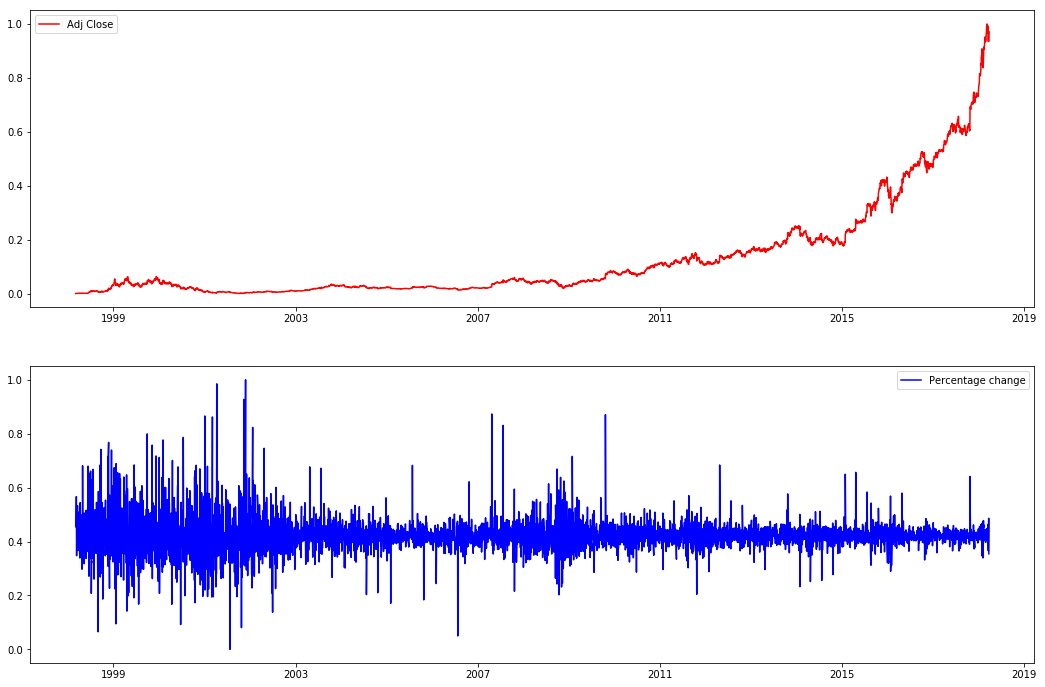

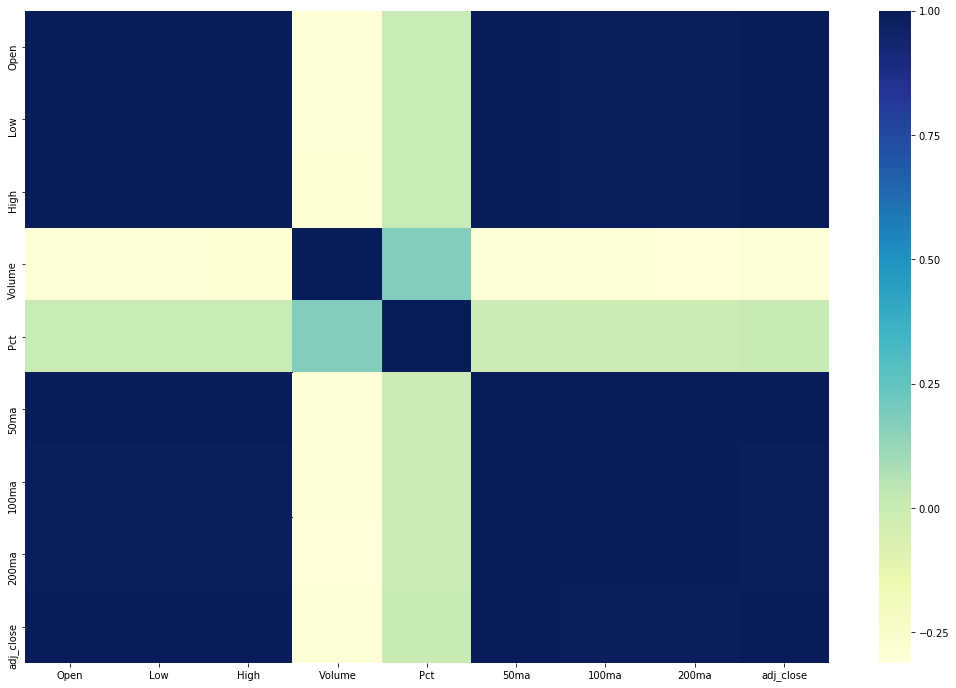

In [8]:
plot_stock_data(df)
plot_stock_corr(df)

In [9]:
## Define a function to eval the mean for few columns.
def show_min_max(data):
    print(data.head())

    print("\n")
    print("Open   - mean :", np.mean(data['Open']),  " Std: ", np.std(data['Open']),  " Max: ", np.max(data['Open']),  " Min: ", np.min(data['Open']))
    print("Low    - mean :", np.mean(data['Low']), " Std: ", np.std(data['Low']), " Max: ", np.max(data['Low']), " Min: ", np.min(data['Low']))
    print("High   - mean :", np.mean(data['High'])," Std: ", np.std(data['High'])," Max: ", np.max(data['High'])," Min: ", np.min(data['High']))
    print("Close  - mean :", np.mean(data['adj_close']), "   Std: ", np.std(data['adj_close']), " Max: ", np.max(data['adj_close']), " Min: ", np.min(data['adj_close']))
    print("Volume - mean :", np.mean(data['Volume'])," Std: ", np.std(data['Volume'])," Max: ", np.max(data['Volume'])," Min: ", np.min(data['Volume']))

In [10]:
show_min_max(df)

                Open       Low      High    Volume       Pct      50ma  \
date                                                                     
1998-03-04  0.000056  0.000204  0.000054  0.061247  0.457843  0.000000   
1998-03-05  0.000043  0.000270  0.000258  0.106602  0.453940  0.000024   
1998-03-06  0.000244  0.000401  0.000197  0.047441  0.457471  0.000047   
1998-03-09  0.000308  0.000559  0.000649  0.213569  0.566548  0.000079   
1998-03-10  0.000755  0.000881  0.000778  0.229964  0.410197  0.000111   

               100ma     200ma  adj_close  
date                                       
1998-03-04  0.000000  0.000000   0.000094  
1998-03-05  0.000019  0.000020   0.000176  
1998-03-06  0.000038  0.000041   0.000267  
1998-03-09  0.000061  0.000065   0.000621  
1998-03-10  0.000083  0.000089   0.000600  


('Open   - mean :', 0.12634242367338944, ' Std: ', 0.1767287238240672, ' Max: ', 1.0, ' Min: ', 0.0)
('Low    - mean :', 0.1269081379555572, ' Std: ', 0.17777602995612357,

In [11]:
## Save to CSV for future use
df.to_csv('amazon_normalized.csv',index = False)

## Section - 1 : Data processing, Design Bench Mark Model, Training, Prediction & Accuracy

### Step : 1 
   **Data Processing, choosing less set of feartures**

In [12]:
## Define a function to process the data
def process_stock_data(data):
    # Define fewer columns of features
    item = []
    open = []
    close = []
    volume = []

    # Loop through the data
    i_counter = 0
    for i in range(len(data) - 1):
        item.append(i_counter)
        open.append(data['Open'][i])
        close.append(data['adj_close'][i])
        volume.append(data['Volume'][i])
        i_counter += 1

    stocks = pd.DataFrame()

    # Add factors to data frame
    stocks['Item'] = item
    stocks['Open'] = open
    stocks['Close'] = pd.to_numeric(close)
    stocks['Volume'] = pd.to_numeric(volume)

    return stocks

In [13]:
regression_df = process_stock_data(df)
regression_df.head()

,Item,Open,Close,Volume
0,0,0.000056,0.000094,0.061247
1,1,0.000043,0.000176,0.106602
2,2,0.000244,0.000267,0.047441
3,3,0.000308,0.000621,0.213569
4,4,0.000755,0.000600,0.229964


In [14]:
## Define visualize function
def price(x):
    return '$%1.2f' % x

def plot_regression_data(stocks, title='Amazon Trading', y_label='Price', x_label='Trading Days'):
    fig, ax = plt.subplots()
    ax.plot(stocks['Item'], stocks['Close'], 'red')

    ax.format_ydata = price
    ax.set_title(title)

    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    plt.show()

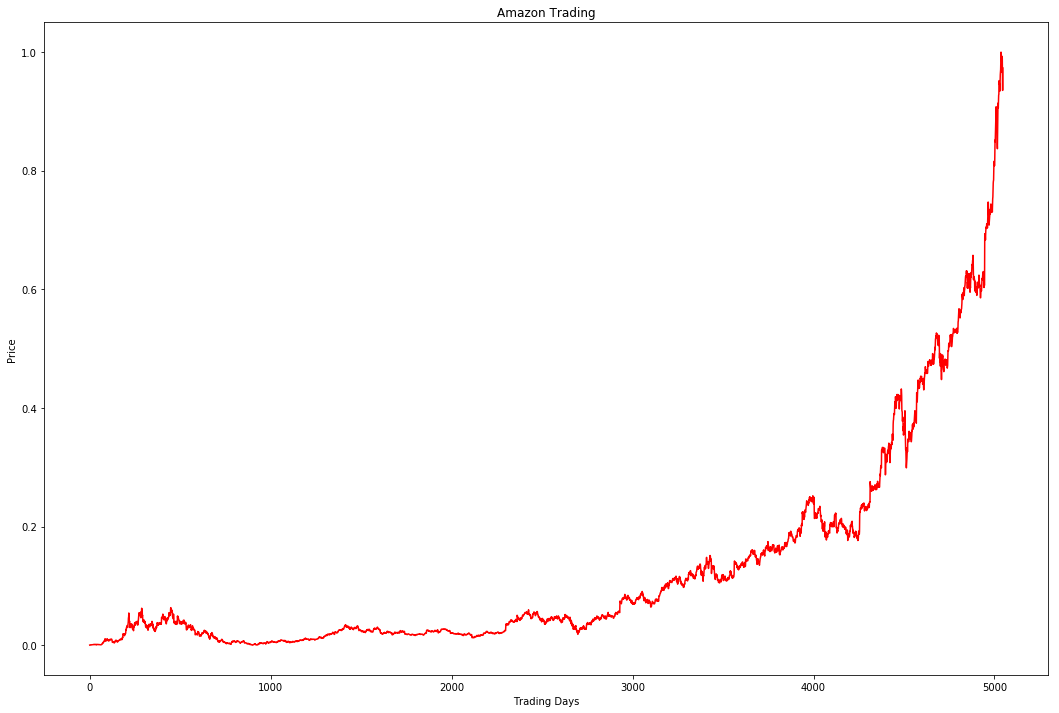

In [15]:
plot_regression_data(regression_df)

### Step : 2
   **Split the data**

In [16]:
## Define the method to split the data into Test and Train for model.
def split_train_test_linear_regression_basic(df):
    adj_close = df['Close'].tolist()
    date      = df['Item'].tolist()
 
    #Convert to 1d Vector
    date = np.reshape(date, (len(date), 1))
    adj_close = np.reshape(adj_close, (len(adj_close), 1))
    X_train, X_test, y_train, y_test = train_test_split(date, adj_close, test_size=0.20, random_state=42)
    return X_train, X_test, y_train, y_test


In [17]:
# X_train, X_test, y_train, y_test, label_range= split_train_test_linear_regression(regression_df)
X_train, X_test, y_train, y_test = split_train_test_linear_regression_basic(regression_df)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

('x_train', (4037, 1))
('y_train', (4037, 1))
('x_test', (1010, 1))
('y_test', (1010, 1))


### Step : 3
   **Design the Benchmark Regression Model **

In [18]:
## Define a function for Linear Regression.
def build_linear_regression_model_basic(X, y):
    linear_mdl = linear_model.LinearRegression()  
    linear_mdl.fit(X, y)  

    return linear_mdl

### Step : 4
   **Compile the model and fit the data **

In [19]:
regression_model = build_linear_regression_model_basic(X_train,y_train)

### Step : 5
   **Use the model for data prediction **

In [20]:
predictions = regression_model.predict(X_test)

### Step : 6
   **Use prediction data to visualize **

In [21]:
def plot_func(regressor,X_test,y_test ):
    #plotting the actual datapoints
    plt.scatter(X_test, y_test, color='red', label= 'Actual Price') 
    #plotting the line made by prediction
    plt.plot(X_test, regressor.predict(X_test), color='blue', linewidth=2, label = 'Predicted Price') 
    plt.title('Linear Regression | Time vs. Normalized Price')
    plt.legend()
    plt.xlabel('Date Integer')
    plt.show()

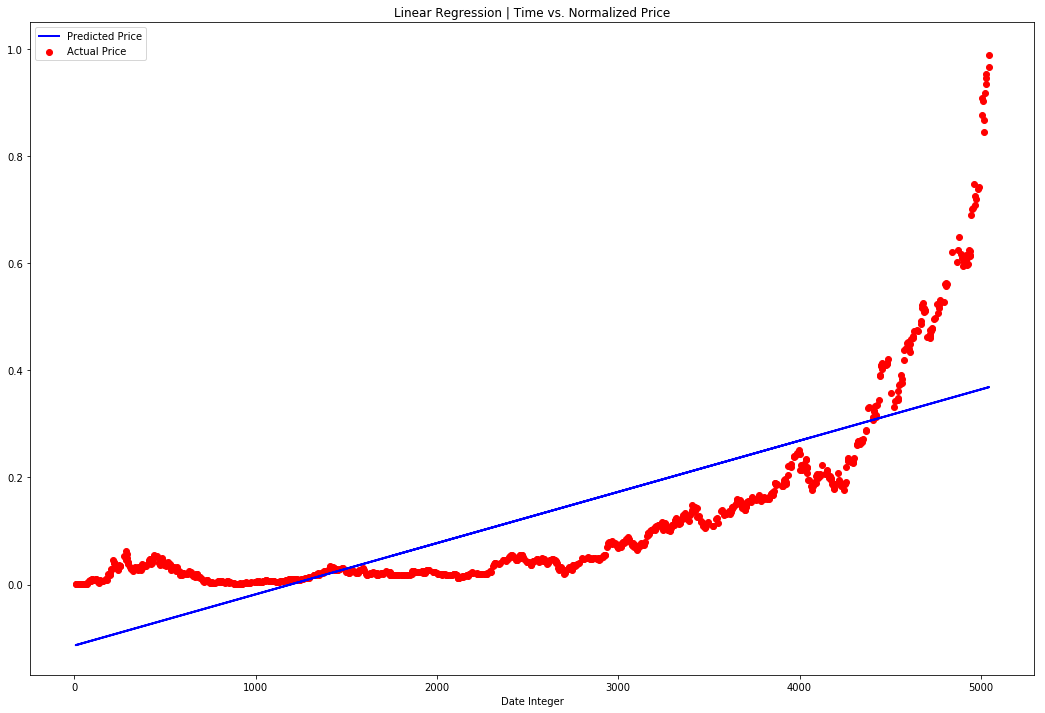

In [22]:
plot_func(regression_model,X_test,y_test)

### Step : 7
   **Calculate the model error **

In [23]:
def calculate_model_error_accuracy(X_train, y_train, y_test,predictions):
    trainScore = mean_squared_error(X_train, y_train)
    print('Train Score: %.4f MSE (%.4f RMSE)' % (trainScore, math.sqrt(trainScore)))

    testScore = mean_squared_error(predictions, y_test)
    print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))


In [24]:
## Calculate the errors
calculate_model_error_accuracy(X_train, y_train, y_test,predictions)

Train Score: 8590708.9592 MSE (2930.9911 RMSE)
Test Score: 0.01244649 MSE (0.11156384 RMSE)


## Section - 2 : Data Split, Design LSTM Model, Training, Prediction & Accuracy

### Step : 1
**Define the split function for LSTM model**

In [25]:
## Define the Data split function based on a sequence length.

def split_train_test_lstm(stock, seq_len):
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    result = []

    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days

    result = np.array(result)
    row = round(0.8 * result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(0.9 * result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * result.shape[0]))

    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price

    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

In [32]:
seq_len = 22
shape = [seq_len, 9, 1]
neurons = [256, 32, 1]
lstm_df = df
X_train, y_train, X_test, y_test = split_train_test_lstm(lstm_df, seq_len)

Amount of features = 9
Amount of training data = 4522.5
Amount of testing data = 502.5


/Users/i850472/local/tools/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


### Step : 2
**Design a basic LSTM model**

In [33]:
def build_basic_model(shape, neurons):
    model = Sequential()

    model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))
    
    model.add(Dense(neurons[2],activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    
    return model

### Step : 3
**Build and compile basic LSTM model**

In [34]:
lstm_basic_model = build_basic_model(shape,neurons)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 256)           272384    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                36992     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 309,409
Trainable params: 309,409
Non-trainable params: 0
_________________________________________________________________


### Step : 4
**Train basic LSTM model**

In [35]:
epochs = 1
lstm_basic_model.fit(X_train, y_train,epochs=epochs,validation_split=0.2)

Train on 3216 samples, validate on 804 samples
Epoch 1/1
3216/3216 [==============================] - 15s 5ms/step - loss: 3.6813e-04 - acc: 3.1095e-04 - val_loss: 6.4520e-05 - val_acc: 0.0000e+00


### Step : 5
**Prediction using basic LSTM model**

In [36]:
predictions = lstm_basic_model.predict(X_test)

In [37]:
## Define a visualize function to plot the lstm prediction..
def plot_lstm_stock_prediction(actual, prediction, title='Amazon Prediction', y_label='Price', x_label='Trading Days'):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Plot actual and predicted close values

    plt.plot(actual, 'red', label='Adjusted Close')
    plt.plot(prediction, 'blue', label='Predicted Close')

    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')

    plt.show()

### Step : 6
**Plot the predictions using basic LSTM model**

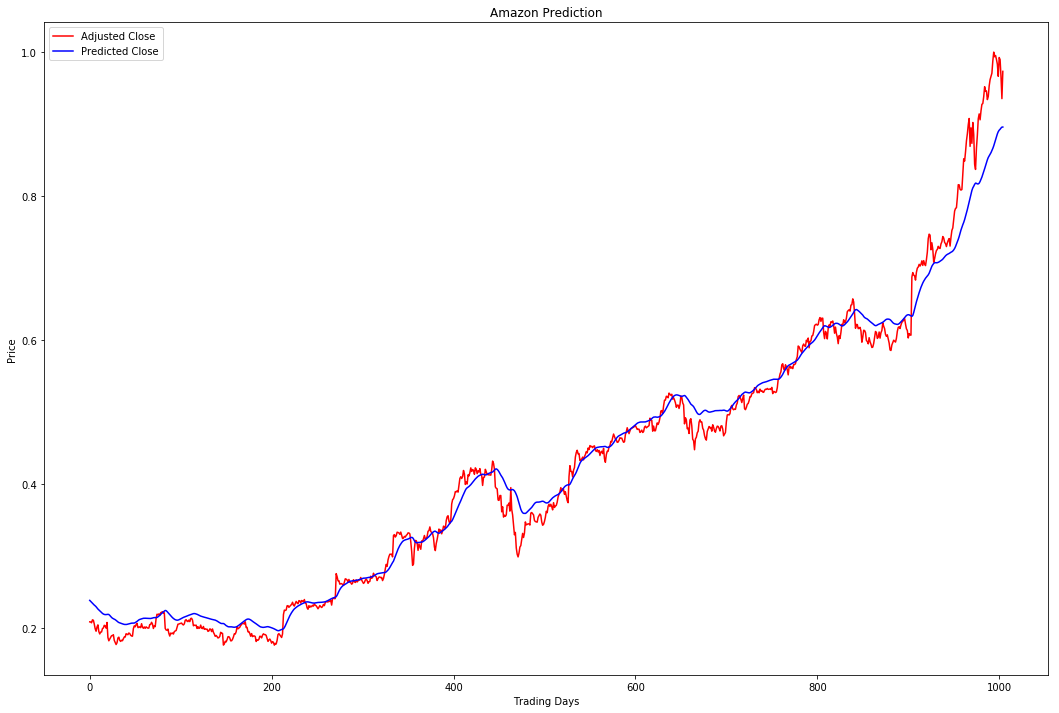

In [38]:
plot_lstm_stock_prediction(y_test,predictions)

### Step : 7
**Error/accuracy score of basic LSTM model**

In [39]:
## Define a function to eval the errors.
def model_lstm_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [40]:
model_lstm_score(lstm_basic_model,X_train, y_train, X_test, y_test)

Train Score: 0.00002310 MSE (0.00480589 RMSE)
Test Score: 0.00075243 MSE (0.02743041 RMSE)


(2.3096622296962503e-05, 0.0007524272861348382)

### Optimised LSTM Model
 **Step : 1 - Build the enhanced Model**

In [41]:
def build_optimized_lstm_model(shape, neurons, dropout):
    model = Sequential()

    model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))

    model.add(Dropout(dropout))
    
    model.add(Dense(neurons[2],activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

#### Step : 2 - Compile the model with optimized params

In [42]:
seq_len = 22
shape = [seq_len, 9, 1]
neurons = [256, 128, 1]
dropout = 0.2
epochs = 20
batch_size = 100
validation_split = 0.2
optimized_lstm_model = build_optimized_lstm_model(shape, neurons, dropout)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 22, 256)           272384    
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 469,633
Trainable params: 469,633
Non-trainable params: 0
_________________________________________________________________


### Step : 3
**Train using Optimized LSTM model**

In [43]:
optimized_lstm_model.fit(
                        X_train,
                        y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=validation_split,
                        verbose=1)

Train on 3216 samples, validate on 804 samples
Epoch 1/20
3216/3216 [==============================] - 12s 4ms/step - loss: 0.0011 - acc: 3.1095e-04 - val_loss: 2.0174e-04 - val_acc: 0.0000e+00
Epoch 2/20
3216/3216 [==============================] - 8s 3ms/step - loss: 4.9422e-05 - acc: 3.1095e-04 - val_loss: 8.0017e-05 - val_acc: 0.0000e+00
Epoch 3/20
3216/3216 [==============================] - 8s 3ms/step - loss: 2.8961e-05 - acc: 3.1095e-04 - val_loss: 5.4974e-05 - val_acc: 0.0000e+00
Epoch 4/20
3216/3216 [==============================] - 8s 3ms/step - loss: 2.3886e-05 - acc: 3.1095e-04 - val_loss: 6.4438e-05 - val_acc: 0.0000e+00
Epoch 5/20
3216/3216 [==============================] - 8s 2ms/step - loss: 2.1915e-05 - acc: 3.1095e-04 - val_loss: 5.4623e-05 - val_acc: 0.0000e+00
Epoch 6/20
3216/3216 [==============================] - 8s 2ms/step - loss: 1.8766e-05 - acc: 3.1095e-04 - val_loss: 5.3266e-05 - val_acc: 0.0000e+00
Epoch 7/20
3216/3216 [==============================] - 

### Step : 4
**Prediction using Optimized LSTM model**

In [44]:
opt_predictions = optimized_lstm_model.predict(X_test)

### Step : 5
**Plot the predictions using Optimized LSTM model**

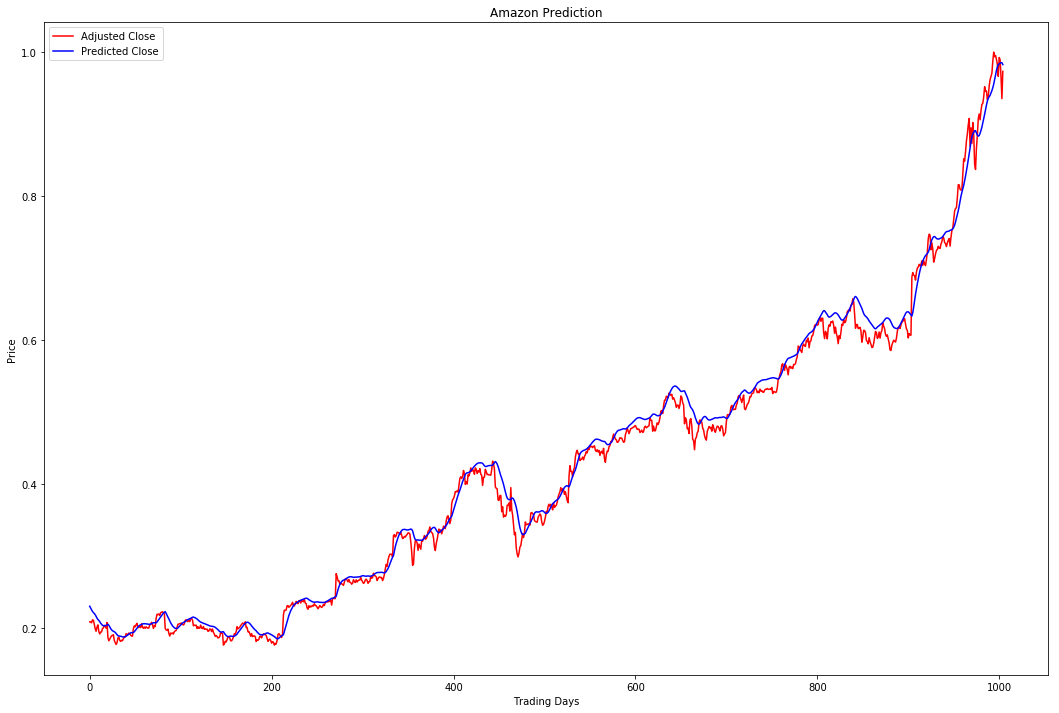

In [45]:
plot_lstm_stock_prediction(y_test,opt_predictions)

### Step : 6
**Error/accuracy score of Optimized LSTM model**

In [46]:
model_lstm_score(optimized_lstm_model,X_train, y_train, X_test, y_test)

Train Score: 0.00001007 MSE (0.00317353 RMSE)
Test Score: 0.00025914 MSE (0.01609795 RMSE)


(1.0071280477330139e-05, 0.0002591439195565731)

### LSTM - Check for Robustness

In [47]:
amazn_unseen_data = pd.read_csv('amazon-unseen.csv') 
amazn_unseen_data.rename(columns={'Date': 'date', 'Adj Close': 'adj_close'}, inplace=True)
# amazn_unseen_data.set_index('date', inplace=True)
amazn_unseen_data.drop(labels=['Close'], axis=1, inplace=True)

##data type conversion
amazn_unseen_data['Open'] = pd.to_numeric(amazn_unseen_data['Open'], errors='coerce')
amazn_unseen_data['Volume'] = np.float64(amazn_unseen_data['Volume'])
amazn_unseen_data['date'] = pd.to_datetime(amazn_unseen_data['date'])
amazn_unseen_data.set_index('date', inplace=True)

## Load the Amazon stock data from Quandl again
amazon_df = download_stock_data('AMZN')
## Append the unseen data into the main set..
merged_df = amazon_df.append(amazn_unseen_data)
## Normalize the full data set and store in a csv for reference.
merged_normalised_df = process_and_normalize(merged_df)
merged_normalised_df.to_csv('amazon_full_set.csv')
## Extract a unseen subset.
df_subset = merged_normalised_df.tail(60)

In [48]:
def process_data_robustness(df, seq=22):
    amount_of_features = len(df_subset.columns)
    data = df.as_matrix()
    sequence_length = seq + 1 
    result = []

    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length]) 

    result = np.array(result)

    X = result[:, :-1] 
    Y = result[:, -1][:,-1] 
    X = np.reshape(X, (X.shape[0], X.shape[1], amount_of_features))
    
    print(X.shape)
    print(Y.shape)
    
    return X,Y

In [49]:
X,Y = process_data_robustness(df_subset)
robust_lstm_predictions = optimized_lstm_model.predict(X)

(37, 22, 9)
(37,)


/Users/i850472/local/tools/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


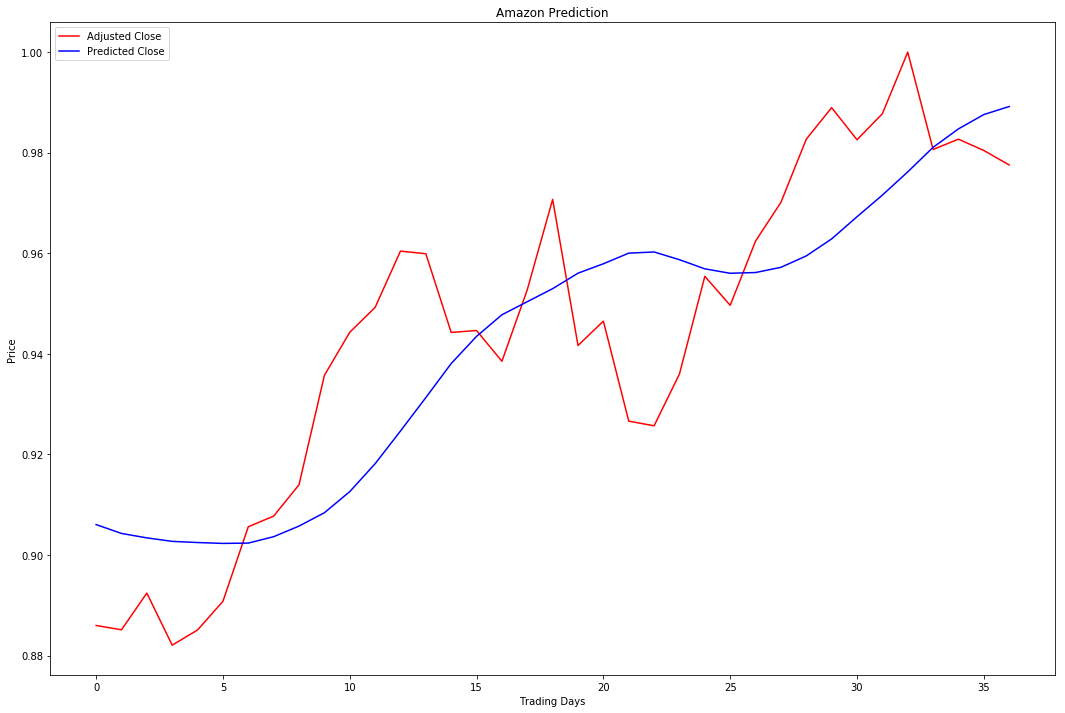

In [50]:
plot_lstm_stock_prediction(Y,robust_lstm_predictions)

In [51]:
testScore = optimized_lstm_model.evaluate(X, Y, verbose=0)
print('LSTM Robustness Test Score: %.8f MSE (%.8f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

LSTM Robustness Test Score: 0.00035123 MSE (0.01874104 RMSE)


## Section - 3 : Data Split, Design GRU Model, Training, Prediction & Accuracy

### Step : 1
**Define the split function for GRU model**

In [77]:
##Define the splity funtion for GRU..
def split_train_test_gru(stock, seq_len, split):
    amount_of_features = len(stock.columns)
    print amount_of_features
    data = stock.values
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
#     scaler = RobustScaler()
#     data = scaler.fit_transform(data)
    
    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length]) 
    
    result = np.array(result)
    
    row = round(split * result.shape[0])
    train = result[:int(row), :]
    X_train = train[:, :, :-1] 
    y_train = train[:, :, -1][:, -1]
    
    X_test = result[int(row):, :, :-1]
    y_test = result[int(row):, :, -1][:, -1]
    
    return [X_train, y_train, X_test, y_test]

In [78]:
gru_df = df
no_of_features = len(gru_df.columns)
seq_len= 21
split = 0.8
layers = [seq_len, 10]
epochs = 1

In [79]:
X_train, y_train, X_test, y_test = split_train_test_gru(gru_df, seq_len, split)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

9


((4021, 22, 8), (4021,), (1005, 22, 8), (1005,))

### Step : 2
**Define the basic GRU model**

In [58]:
## Build the basic model..
def build_basic_gru_model(layers):
        model = Sequential()
        
        model.add(GRU(2048, input_shape=(layers[0]+1, layers[1]-1), return_sequences=True))
        model.add(GRU(1024, return_sequences=True))
        model.add(GRU(512, return_sequences=False))       
        
        model.add(Dense(1, activation='linear'))
        
        model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
        return model

### Step : 3
**Compile the basic GRU model**

In [59]:
gru_basic_model = build_basic_gru_model([seq_len, no_of_features])

### Step : 4
**Train basic GRU model**

In [32]:
gru_basic_model.fit(X_train,
                    y_train,
                    epochs=epochs, 
                    validation_split=0.2)

Train on 3216 samples, validate on 805 samples
Epoch 1/1
3216/3216 [==============================] - 281s 87ms/step - loss: 0.0178 - acc: 3.1095e-04 - val_loss: 6.2196e-05 - val_acc: 0.0000e+00


### Step : 5
**Prediction using Basic GRU model**

In [33]:
predictions = gru_basic_model.predict(X_test)

### Step : 6
**Plot the predictions using Basic GRU model**

In [60]:
plt.rcParams['figure.figsize'] = (18, 12)
## Define a visualize function to plot the gru prediction..
def plot_gru_stock_prediction(actual, prediction, title='Amazon GRU Prediction', y_label='Price', x_label='Trading Days'):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Plot actual and predicted close values

    plt.plot(actual, 'red', label='Adjusted Close')
    plt.plot(prediction, 'blue', label='Predicted Close')

    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')

    plt.show()

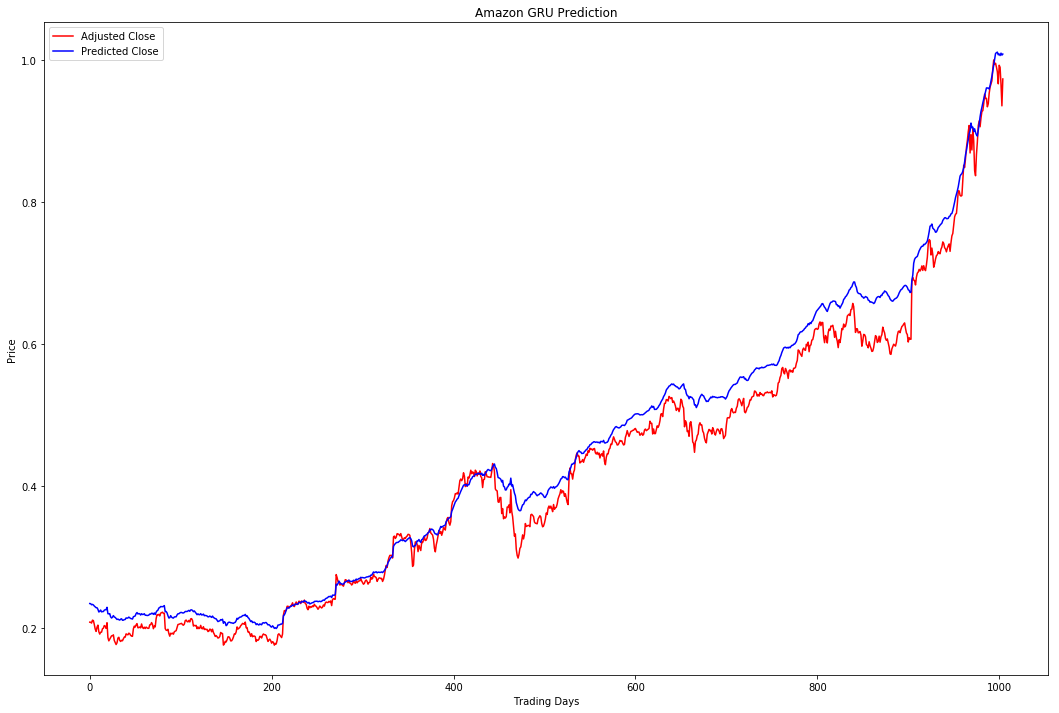

In [38]:
plot_gru_stock_prediction(y_test,predictions)

### Step : 7
**Error/accuracy score of Basic GRU model**

In [68]:
## Define a function to eval the errors.
def model_gru_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [102]:
model_gru_score(gru_basic_model, X_train, y_train, X_test, y_test)

Train Score: 0.00002767 MSE (0.00525995 RMSE)
Test Score: 0.00147107 MSE (0.03835451 RMSE)


(2.7667022326605806e-05, 0.0014710684635894215)

### Optimised GRU Model
 **Step : 1 - Build the enhanced Model**

In [61]:
def build_optimized_gru_model(layers, d):
        model = Sequential()
        
        model.add(GRU(2048, input_shape=(layers[0]+1, layers[1]-1), return_sequences=True))
        model.add(Dropout(d))
        model.add(GRU(1024, return_sequences=True))
        model.add(Dropout(d))
        model.add(GRU(512, return_sequences=False))       
        model.add(Dropout(d))
        model.add(Dense(1, activation='linear'))
        
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

### Step : 2
**Compile the enhanced GRU model**

In [63]:
gru_df = df
no_of_features = len(gru_df.columns)
seq_len= 21
split = 0.8
layers = [seq_len, 10]
epochs = 5
batch_size = 100
gru_opt_model = build_optimized_gru_model([seq_len, no_of_features],0.2)

### Step : 3
**Train the enhanced GRU model**

In [64]:
gru_opt_model.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs, 
                validation_split=0.2)

Train on 3216 samples, validate on 805 samples
Epoch 1/5
3216/3216 [==============================] - 121s 37ms/step - loss: 0.0173 - acc: 3.1095e-04 - val_loss: 3.6129e-04 - val_acc: 0.0000e+00
Epoch 2/5
3216/3216 [==============================] - 104s 32ms/step - loss: 2.0520e-04 - acc: 3.1095e-04 - val_loss: 4.4539e-05 - val_acc: 0.0000e+00
Epoch 3/5
3216/3216 [==============================] - 104s 32ms/step - loss: 5.2118e-05 - acc: 3.1095e-04 - val_loss: 2.3798e-05 - val_acc: 0.0000e+00
Epoch 4/5
3216/3216 [==============================] - 104s 32ms/step - loss: 3.8950e-05 - acc: 3.1095e-04 - val_loss: 2.3239e-05 - val_acc: 0.0000e+00
Epoch 5/5
3216/3216 [==============================] - 103s 32ms/step - loss: 3.1730e-05 - acc: 3.1095e-04 - val_loss: 2.5165e-05 - val_acc: 0.0000e+00


### Step : 4
**Prediction using Optimized GRU model**

In [65]:
opt_predictions = gru_opt_model.predict(X_test)

### Step : 5
**Plot the predictions using Optimized GRU model**

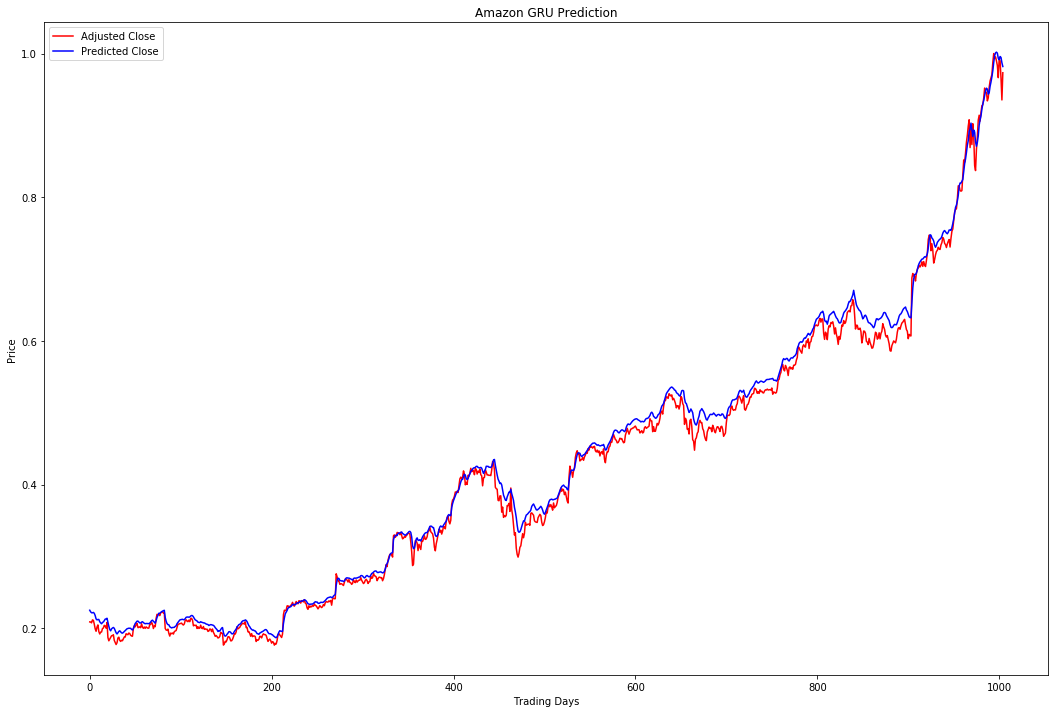

In [66]:
plot_gru_stock_prediction(y_test,opt_predictions)

### Step : 6
**Error/accuracy score of Optimized GRU model**

In [69]:
model_gru_score(gru_opt_model, X_train, y_train, X_test, y_test)

Train Score: 0.00000714 MSE (0.00267198 RMSE)
Test Score: 0.00018496 MSE (0.01359992 RMSE)


(7.139469949721977e-06, 0.00018495787702505455)

### GRU - Check for Robustness

In [93]:
## Split the Data set needed for GRU..
def split_train_test_gru_robust(stock, seq_len, split):
    amount_of_features = len(stock.columns)
    print amount_of_features
    data = stock.values
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length]) 
    
    result = np.array(result)
    
    X= result[:, :, :-1] 
    Y = result[:, :, -1][:, -1]
    
    return X, Y

In [98]:
## Split the data and run the prediction on unseen data set
X,Y = split_train_test_gru_robust(df_subset, 21, 0.8)
robust_gru_predictions = gru_opt_model.predict(X)

9


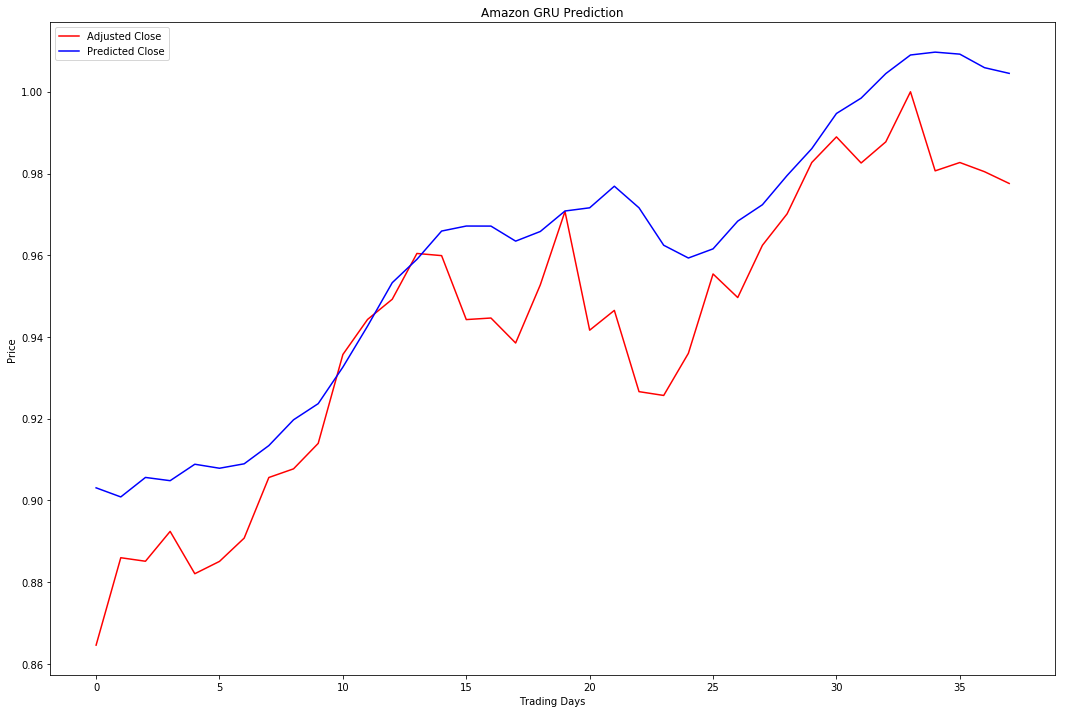

In [99]:
## Plot the Data
plot_gru_stock_prediction(Y,robust_gru_predictions)

In [100]:
testScore = gru_opt_model.evaluate(X, Y, verbose=0)
print('GRU Robustness Test Score: %.8f MSE (%.8f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

GRU Robustness Test Score: 0.00041906 MSE (0.02047094 RMSE)
